In [2]:
!pip install -q flwr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 598.1/598.1 kB 9.8 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 2.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.8 which is incompatible.
google-spark-connect 0.5.2 requires google-api-core>=2.19.1, but you have google-api-core 1.34.1 which is incompatible.
google-cloud-bigtable 2.30.0 requires google-api-core[grpc]<3.0.0,>=2.16.0, but you have google-api-core 1.34.

In [3]:
!pip install -U flwr

In [4]:
# --- Imports ---
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import pandas as pd
import gc
import time
import flwr as fl
from flwr.client import NumPyClient
from flwr.common import Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedProx

# --- Load and prepare data ---
data = np.load("/kaggle/input/daicwoz-balanced/dataset_balanced.npz")
test_ids = np.load("/kaggle/input/daicwoz-balanced/test_ids (1).npy")

X_audio_test = data["X_audio_test"]
X_text_test = data["X_text_test"]
y_test = data["y_test"]

X_audio_dev = data["X_audio_dev"]
X_text_dev = data["X_text_dev"]
y_dev = data["y_dev"]

X_audio_train = data["X_audio_train"]
X_text_train = data["X_text_train"]
y_train = data["y_train"]

y_train = y_train.reshape(-1, 1)
y_dev = y_dev.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# --- Parameters ---
NUM_CLIENTS = 10
input_shape_audio = (378, 60)
input_shape_text = (378, 9)

# --- Build model ---
def build_model():
    input_audio = layers.Input(shape=input_shape_audio, name='mfcc_input')
    x_audio = layers.LSTM(60, return_sequences=True, recurrent_dropout=0.002,
                          bias_regularizer=regularizers.l1_l2(1e-4, 1e-4))(input_audio)
    x_audio = layers.BatchNormalization()(x_audio)
    x_audio = layers.Dropout(2e-4)(x_audio)
    x_audio = layers.LSTM(40, return_sequences=True, recurrent_dropout=0.002,
                          bias_regularizer=regularizers.l1_l2(1e-4, 1e-4))(x_audio)
    x_audio = layers.BatchNormalization()(x_audio)
    x_audio = layers.Dropout(2e-4)(x_audio)
    x_audio = layers.LSTM(20, return_sequences=False, recurrent_dropout=0.002,
                          bias_regularizer=regularizers.l1_l2(1e-4, 1e-4))(x_audio)
    x_audio = layers.BatchNormalization()(x_audio)
    x_audio = layers.Dropout(2e-4)(x_audio)

    input_text = layers.Input(shape=input_shape_text, name='text_input')
    x_text = layers.Flatten()(input_text)

    x = layers.Concatenate()([x_audio, x_text])
    x = layers.Reshape((1, -1))(x)
    x = layers.LSTM(20, return_sequences=False, recurrent_dropout=0.002)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(2e-4)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(15, activation='tanh')(x)
    x = layers.Dense(10, activation='tanh')(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    return models.Model(inputs=[input_audio, input_text], outputs=output)

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def compile_model():
    model = build_model()
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(1e-5),
        loss=rmse,
        metrics=['accuracy', 'mae', rmse]
    )
    return model

def split_data(num_clients):
    size = len(y_train) // num_clients
    return [
        (X_audio_train[i * size : (i + 1) * size if i != num_clients - 1 else None],
         X_text_train[i * size : (i + 1) * size if i != num_clients - 1 else None],
         y_train[i * size : (i + 1) * size if i != num_clients - 1 else None])
        for i in range(num_clients)
    ]

client_datasets = split_data(NUM_CLIENTS)

def get_model_size(weights):
    return sum([w.nbytes for w in weights])

# --- Flower Client ---
class DepressionClient(NumPyClient):
    def __init__(self, model, X_audio_c, X_text_c, y_c):
        self.model = model
        self.X_audio_train = X_audio_c
        self.X_text_train = X_text_c
        self.y_train = y_c
        self.X_audio_test = X_audio_dev
        self.X_text_test = X_text_dev
        self.y_test = y_dev

    def get_parameters(self, config=None):
        return self.model.get_weights()

    def set_parameters(self, parameters):
        self.model.set_weights(parameters)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        self.model.fit(
            [self.X_audio_train, self.X_text_train],
            self.y_train,
            batch_size=8,
            epochs=2,
            verbose=0,
            shuffle=True,
        )
        return self.get_parameters(), len(self.y_train), {}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        loss, acc, mae, rmse_val = self.model.evaluate(
            [self.X_audio_test, self.X_text_test], self.y_test, verbose=0
        )
        return float(loss), len(self.y_test), {
            "accuracy": float(acc),
            "mae": float(mae),
            "rmse": float(rmse_val)
        }

# --- Simulation loop over multiple proximal_mu ---
results = {}
proximal_mu_values = [0.0, 0.01, 0.1, 0.5]

for proximal_mu in proximal_mu_values:
    print(f"\n🚀 Testing FedProx with proximal_mu = {proximal_mu}")

    global_metrics = {
        "accuracy": [],
        "mae": [],
        "rmse": [],
        "f1_score": [],
        "precision": [],
        "recall": [],
        "comm_bytes": [],
        "round_time_sec": []
    }

    # --- Client App ---
    def client_fn(context: Context):
        partition_id = int(context.node_config.get("partition-id", 0))
        model = compile_model()
        X_audio_c, X_text_c, y_c = client_datasets[partition_id]
        return DepressionClient(model, X_audio_c, X_text_c, y_c).to_client()

    client_app = fl.client.ClientApp(client_fn=client_fn)

    # --- Server App ---
    def server_fn(context: Context) -> ServerAppComponents:
        model = compile_model()

        def evaluate_fn(server_round, parameters, _config):
            start = time.time()

            model.set_weights(parameters)
            y_pred = model.predict([X_audio_test, X_text_test], verbose=0)
            y_pred_labels = (y_pred > 0.5).astype(int)

            acc = accuracy_score(y_test, y_pred_labels)
            f1 = f1_score(y_test, y_pred_labels)
            prec = precision_score(y_test, y_pred_labels)
            rec = recall_score(y_test, y_pred_labels)
            mae_val = np.mean(np.abs(y_test - y_pred))
            rmse_val = np.sqrt(np.mean((y_test - y_pred) ** 2))

            bytes_per_round = get_model_size(parameters) * NUM_CLIENTS * 2
            round_time = time.time() - start

            global_metrics["accuracy"].append(acc)
            global_metrics["mae"].append(mae_val)
            global_metrics["rmse"].append(rmse_val)
            global_metrics["f1_score"].append(f1)
            global_metrics["precision"].append(prec)
            global_metrics["recall"].append(rec)
            global_metrics["comm_bytes"].append(bytes_per_round)
            global_metrics["round_time_sec"].append(round_time)

            print(f"📊 Round {server_round} — Acc: {acc:.4f}, F1: {f1:.4f}, MAE: {mae_val:.4f}, RMSE: {rmse_val:.4f}")

            tf.keras.backend.clear_session()
            gc.collect()

            return float(rmse_val), {
                "accuracy": float(acc),
                "f1_score": float(f1),
                "precision": float(prec),
                "recall": float(rec),
                "mae": float(mae_val),
                "rmse": float(rmse_val),
                "comm_bytes": bytes_per_round,
                "round_time_sec": round_time
            }

        strategy = FedProx(
            fraction_fit=0.8,
            fraction_evaluate=0.5,
            min_fit_clients=NUM_CLIENTS,
            min_evaluate_clients=5,
            min_available_clients=NUM_CLIENTS,
            evaluate_fn=evaluate_fn,
            proximal_mu=proximal_mu,
        )

        return ServerAppComponents(strategy=strategy, config=ServerConfig(num_rounds=5))

    server_app = ServerApp(server_fn=server_fn)

    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}
    fl.simulation.run_simulation(
        server_app=server_app,
        client_app=client_app,
        num_supernodes=NUM_CLIENTS,
        backend_config=backend_config,
    )

    results[proximal_mu] = global_metrics



🚀 Testing FedProx with proximal_mu = 0.0


2025-07-05 20:19:51.695140: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=562) 2025-07-05 20:20:02.534790: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=562) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=562) E0000 00:00:1751746802.578004     562 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=562) E0000 00:00:1751746802.591997     562 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plug

📊 Round 0 — Acc: 0.5129, F1: 0.2582, MAE: 0.4998, RMSE: 0.5003


INFO :      initial parameters (loss, other metrics): 0.5002860426902771, {'accuracy': 0.5129310344827587, 'f1_score': 0.25820568927789933, 'precision': 0.5412844036697247, 'recall': 0.16954022988505746, 'mae': 0.4997749626636505, 'rmse': 0.5002860426902771, 'comm_bytes': 26125280, 'round_time_sec': 11.886918067932129}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=562) 2025-07-05 20:20:27.285409: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
(ClientAppActor pid=565) 2025-07-05 20:20:27.272404: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 1 — Acc: 0.5280, F1: 0.4757, MAE: 0.4993, RMSE: 0.5010


INFO :      fit progress: (1, 0.5010045170783997, {'accuracy': 0.5280172413793104, 'f1_score': 0.47565841979249807, 'precision': 0.5350089766606823, 'recall': 0.4281609195402299, 'mae': 0.4992638826370239, 'rmse': 0.5010045170783997, 'comm_bytes': 26125280, 'round_time_sec': 6.0293354988098145}, 998.3759645969999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 2 — Acc: 0.5381, F1: 0.4802, MAE: 0.4978, RMSE: 0.5053


INFO :      fit progress: (2, 0.5053458213806152, {'accuracy': 0.5380747126436781, 'f1_score': 0.48019401778496357, 'precision': 0.5489833641404805, 'recall': 0.4267241379310345, 'mae': 0.4977778196334839, 'rmse': 0.5053458213806152, 'comm_bytes': 26125280, 'round_time_sec': 6.099113941192627}, 1993.741679795)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 3 — Acc: 0.5165, F1: 0.4488, MAE: 0.4977, RMSE: 0.5115


INFO :      fit progress: (3, 0.5114911198616028, {'accuracy': 0.5165229885057471, 'f1_score': 0.44881244881244875, 'precision': 0.5219047619047619, 'recall': 0.3936781609195402, 'mae': 0.49771592020988464, 'rmse': 0.5114911198616028, 'comm_bytes': 26125280, 'round_time_sec': 6.237493515014648}, 3080.6968565079997)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(raylet) Spilled 4016 MiB, 4 objects, write throughput 185 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(ClientAppActor pid=564) 2025-07-05 20:20:27.268100: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(raylet) Spilled 8033 MiB, 8 objects, write throughput 286 MiB/s.
INFO :      aggregate_fit: received 10 results and 

📊 Round 4 — Acc: 0.5187, F1: 0.4417, MAE: 0.4981, RMSE: 0.5133


INFO :      fit progress: (4, 0.5133332014083862, {'accuracy': 0.5186781609195402, 'f1_score': 0.4416666666666667, 'precision': 0.5257936507936508, 'recall': 0.3807471264367816, 'mae': 0.498073548078537, 'rmse': 0.5133332014083862, 'comm_bytes': 26125280, 'round_time_sec': 6.408257722854614}, 4177.726549538)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(raylet) Spilled 9037 MiB, 9 objects, write throughput 251 MiB/s.
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 5 — Acc: 0.5115, F1: 0.4188, MAE: 0.4989, RMSE: 0.5143


INFO :      fit progress: (5, 0.5143429040908813, {'accuracy': 0.5114942528735632, 'f1_score': 0.41880341880341876, 'precision': 0.5168776371308017, 'recall': 0.35201149425287354, 'mae': 0.4988568127155304, 'rmse': 0.5143429040908813, 'comm_bytes': 26125280, 'round_time_sec': 6.702914476394653}, 5280.141239957)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 5316.97s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.5236245393753052
INFO :      		round 2: 0.524275004863739
INFO :      		round 3: 0.527940034866333
INFO :      		round 4: 0.5291256308555603
INFO :      		round 5: 0.5292810797691345
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.5002860426902771
INFO :      		round 1: 0.5010045170783997
INFO :      		round 2: 0.5053458213806152
INFO :      		round 3: 0.5114911198616028
INFO : 


🚀 Testing FedProx with proximal_mu = 0.01


INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=12814) 2025-07-05 21:49:14.596544: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=12814) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=12814) E0000 00:00:1751752154.672869   12814 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=12814) E0000 00:00:1751752154.685907   12814 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=12809) 2025-07-05 21:49:28.301339: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed

📊 Round 0 — Acc: 0.5287, F1: 0.5015, MAE: 0.4998, RMSE: 0.5000


INFO :      initial parameters (loss, other metrics): 0.5000001192092896, {'accuracy': 0.5287356321839081, 'f1_score': 0.5015197568389058, 'precision': 0.532258064516129, 'recall': 0.47413793103448276, 'mae': 0.49983784556388855, 'rmse': 0.5000001192092896, 'comm_bytes': 26125280, 'round_time_sec': 9.883633136749268}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=12812) 2025-07-05 21:49:41.867187: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
(ClientAppActor pid=12814) 2025-07-05 21:49:42.704354: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 1 — Acc: 0.5158, F1: 0.4448, MAE: 0.4992, RMSE: 0.5005


INFO :      fit progress: (1, 0.5005282759666443, {'accuracy': 0.5158045977011494, 'f1_score': 0.4448105436573312, 'precision': 0.5212355212355212, 'recall': 0.3879310344827586, 'mae': 0.4992474615573883, 'rmse': 0.5005282759666443, 'comm_bytes': 26125280, 'round_time_sec': 6.43324089050293}, 1065.9639940569996)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(raylet) Spilled 3012 MiB, 3 objects, write throughput 181 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(ClientAppActor pid=12811) 2025-07-05 21:49:42.754816: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
(raylet) Spilled 5020 MiB, 5 objects, write throughput 275 MiB/s.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(raylet) Spilled 9039 MiB, 11 objects, write through

📊 Round 2 — Acc: 0.5180, F1: 0.4602, MAE: 0.4971, RMSE: 0.5026


INFO :      fit progress: (2, 0.5025846362113953, {'accuracy': 0.5179597701149425, 'f1_score': 0.46017699115044247, 'precision': 0.5228519195612431, 'recall': 0.4109195402298851, 'mae': 0.49712538719177246, 'rmse': 0.5025846362113953, 'comm_bytes': 26125280, 'round_time_sec': 6.21394419670105}, 2273.1599828490007)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(raylet) Spilled 17078 MiB, 23 objects, write throughput 296 MiB/s.
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 3 — Acc: 0.5187, F1: 0.4579, MAE: 0.4972, RMSE: 0.5057


INFO :      fit progress: (3, 0.5056543946266174, {'accuracy': 0.5186781609195402, 'f1_score': 0.4579288025889967, 'precision': 0.524074074074074, 'recall': 0.40660919540229884, 'mae': 0.4972399175167084, 'rmse': 0.5056543946266174, 'comm_bytes': 26125280, 'round_time_sec': 6.319840908050537}, 3448.687695464)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 4 — Acc: 0.5122, F1: 0.4402, MAE: 0.4983, RMSE: 0.5073


INFO :      fit progress: (4, 0.5073460340499878, {'accuracy': 0.5122126436781609, 'f1_score': 0.4402308326463314, 'precision': 0.5164410058027079, 'recall': 0.38362068965517243, 'mae': 0.4982723295688629, 'rmse': 0.5073460340499878, 'comm_bytes': 26125280, 'round_time_sec': 6.656956911087036}, 4630.3378372180005)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 5 — Acc: 0.5050, F1: 0.4263, MAE: 0.4991, RMSE: 0.5084


INFO :      fit progress: (5, 0.5083621740341187, {'accuracy': 0.5050287356321839, 'f1_score': 0.42631140716069943, 'precision': 0.5069306930693069, 'recall': 0.367816091954023, 'mae': 0.49905869364738464, 'rmse': 0.5083621740341187, 'comm_bytes': 26125280, 'round_time_sec': 6.362263202667236}, 5865.768143585)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(raylet) Spilled 33148 MiB, 42 objects, write throughput 278 MiB/s.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 5918.77s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.5251436829566956
INFO :      		round 2: 0.5290790796279907
INFO :      		round 3: 0.5325895547866821
INFO :      		round 4: 0.533307671546936
INFO :      		round 5: 0.5333527326583862
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.5000001192092896
INFO :      		round 1: 0.5005282759666443
INFO :      		round 2: 


🚀 Testing FedProx with proximal_mu = 0.1


INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=25269) 2025-07-05 23:28:31.464968: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=25269) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=25269) E0000 00:00:1751758111.514680   25269 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=25269) E0000 00:00:1751758111.530811   25269 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=25271) 2025-07-05 23:28:40.827642: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed

📊 Round 0 — Acc: 0.4871, F1: 0.4186, MAE: 0.4993, RMSE: 0.5005


INFO :      initial parameters (loss, other metrics): 0.5005174279212952, {'accuracy': 0.4870689655172414, 'f1_score': 0.4185667752442997, 'precision': 0.4830827067669173, 'recall': 0.3692528735632184, 'mae': 0.4992993175983429, 'rmse': 0.5005174279212952, 'comm_bytes': 26125280, 'round_time_sec': 9.449182271957397}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=25269) 2025-07-05 23:28:54.578159: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
(ClientAppActor pid=25267) 2025-07-05 23:28:54.580559: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 1 — Acc: 0.5043, F1: 0.5746, MAE: 0.5000, RMSE: 0.5024


INFO :      fit progress: (1, 0.5023818016052246, {'accuracy': 0.5043103448275862, 'f1_score': 0.5745992601726264, 'precision': 0.5032397408207343, 'recall': 0.6695402298850575, 'mae': 0.49995216727256775, 'rmse': 0.5023818016052246, 'comm_bytes': 26125280, 'round_time_sec': 6.3468873500823975}, 1064.367712546)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 2 — Acc: 0.4540, F1: 0.4947, MAE: 0.5076, RMSE: 0.5165


INFO :      fit progress: (2, 0.5165064930915833, {'accuracy': 0.4540229885057471, 'f1_score': 0.49468085106382975, 'precision': 0.4603960396039604, 'recall': 0.5344827586206896, 'mae': 0.5075749158859253, 'rmse': 0.5165064930915833, 'comm_bytes': 26125280, 'round_time_sec': 7.760512828826904}, 2150.5512505179995)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(raylet) Spilled 3012 MiB, 3 objects, write throughput 221 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(ClientAppActor pid=25270) 2025-07-05 23:28:54.557523: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 3 — Acc: 0.4648, F1: 0.4510, MAE: 0.5102, RMSE: 0.5252


INFO :      fit progress: (3, 0.5252001881599426, {'accuracy': 0.46479885057471265, 'f1_score': 0.4509948415622697, 'precision': 0.4629349470499244, 'recall': 0.4396551724137931, 'mae': 0.51015305519104, 'rmse': 0.5252001881599426, 'comm_bytes': 26125280, 'round_time_sec': 6.519618511199951}, 3248.346674586999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(raylet) Spilled 5020 MiB, 5 objects, write throughput 201 MiB/s.
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 4 — Acc: 0.4619, F1: 0.4278, MAE: 0.5104, RMSE: 0.5265


INFO :      fit progress: (4, 0.5264836549758911, {'accuracy': 0.4619252873563218, 'f1_score': 0.42780748663101603, 'precision': 0.4567699836867863, 'recall': 0.40229885057471265, 'mae': 0.5103635191917419, 'rmse': 0.5264836549758911, 'comm_bytes': 26125280, 'round_time_sec': 6.83636999130249}, 4352.876553620999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(raylet) Spilled 9037 MiB, 9 objects, write throughput 232 MiB/s.
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 5 — Acc: 0.4634, F1: 0.4141, MAE: 0.5102, RMSE: 0.5260


INFO :      fit progress: (5, 0.5259699821472168, {'accuracy': 0.46336206896551724, 'f1_score': 0.41411764705882353, 'precision': 0.45595854922279794, 'recall': 0.3793103448275862, 'mae': 0.510235607624054, 'rmse': 0.5259699821472168, 'comm_bytes': 26125280, 'round_time_sec': 6.6616175174713135}, 5439.773462955998)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 5482.42s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.5274398922920227
INFO :      		round 2: 0.5422004461288452
INFO :      		round 3: 0.5537118315696716
INFO :      		round 4: 0.5543842315673828
INFO :      		round 5: 0.5525528788566589
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.5005174279212952
INFO :      		round 1: 0.5023818016052246
INFO :      		round 2: 0.5165064930915833
INFO :      		round 3: 0.5252001881599426
I


🚀 Testing FedProx with proximal_mu = 0.5


INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=37655) 2025-07-06 01:00:27.903932: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=37655) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=37655) E0000 00:00:1751763627.951621   37655 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=37655) E0000 00:00:1751763627.965359   37655 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=37654) 2025-07-06 01:00:51.109117: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed

📊 Round 0 — Acc: 0.4770, F1: 0.5630, MAE: 0.5001, RMSE: 0.5005


INFO :      initial parameters (loss, other metrics): 0.5005314946174622, {'accuracy': 0.47701149425287354, 'f1_score': 0.5630252100840336, 'precision': 0.48350515463917526, 'recall': 0.6738505747126436, 'mae': 0.5000894069671631, 'rmse': 0.5005314946174622, 'comm_bytes': 26125280, 'round_time_sec': 10.1562819480896}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=37655) 2025-07-06 01:01:08.610436: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
(ClientAppActor pid=37651) 2025-07-06 01:01:08.673678: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 1 — Acc: 0.4705, F1: 0.4632, MAE: 0.5029, RMSE: 0.5062


INFO :      fit progress: (1, 0.506194531917572, {'accuracy': 0.47054597701149425, 'f1_score': 0.4632192279679534, 'precision': 0.46971935007385524, 'recall': 0.45689655172413796, 'mae': 0.502880871295929, 'rmse': 0.506194531917572, 'comm_bytes': 26125280, 'round_time_sec': 6.262895822525024}, 1035.0525123820007)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 2 — Acc: 0.4799, F1: 0.4308, MAE: 0.5083, RMSE: 0.5210


INFO :      fit progress: (2, 0.5210408568382263, {'accuracy': 0.47988505747126436, 'f1_score': 0.4308176100628931, 'precision': 0.4756944444444444, 'recall': 0.3936781609195402, 'mae': 0.5082594156265259, 'rmse': 0.5210408568382263, 'comm_bytes': 26125280, 'round_time_sec': 6.275085210800171}, 2085.7083204209994)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(raylet) Spilled 3012 MiB, 3 objects, write throughput 223 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(ClientAppActor pid=37653) 2025-07-06 01:01:08.609954: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 3 — Acc: 0.5014, F1: 0.4339, MAE: 0.5077, RMSE: 0.5273


INFO :      fit progress: (3, 0.5273427963256836, {'accuracy': 0.5014367816091954, 'f1_score': 0.43393148450244695, 'precision': 0.5018867924528302, 'recall': 0.382183908045977, 'mae': 0.507698118686676, 'rmse': 0.5273427963256836, 'comm_bytes': 26125280, 'round_time_sec': 10.044531106948853}, 3150.204299765999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 4 — Acc: 0.5036, F1: 0.4227, MAE: 0.5061, RMSE: 0.5265


INFO :      fit progress: (4, 0.526542603969574, {'accuracy': 0.5035919540229885, 'f1_score': 0.4227234753550543, 'precision': 0.5049900199600799, 'recall': 0.3635057471264368, 'mae': 0.5060585141181946, 'rmse': 0.526542603969574, 'comm_bytes': 26125280, 'round_time_sec': 6.1210713386535645}, 4233.404169074998)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(raylet) Spilled 7029 MiB, 7 objects, write throughput 200 MiB/s.
INFO :      aggregate_fit: received 10 results and 0 failures


📊 Round 5 — Acc: 0.5086, F1: 0.4164, MAE: 0.5053, RMSE: 0.5250


INFO :      fit progress: (5, 0.5250089764595032, {'accuracy': 0.5086206896551724, 'f1_score': 0.41638225255972694, 'precision': 0.5126050420168067, 'recall': 0.3505747126436782, 'mae': 0.5053104162216187, 'rmse': 0.5250089764595032, 'comm_bytes': 26125280, 'round_time_sec': 8.437398672103882}, 5381.161235274001)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 5421.18s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.5275000929832458
INFO :      		round 2: 0.5333454012870789
INFO :      		round 3: 0.5354105234146118
INFO :      		round 4: 0.5354074239730835
INFO :      		round 5: 0.534512460231781
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.5005314946174622
INFO :      		round 1: 0.506194531917572
INFO :      		round 2: 0.5210408568382263
INFO :      		round 3: 0.5273427963256836
INFO 

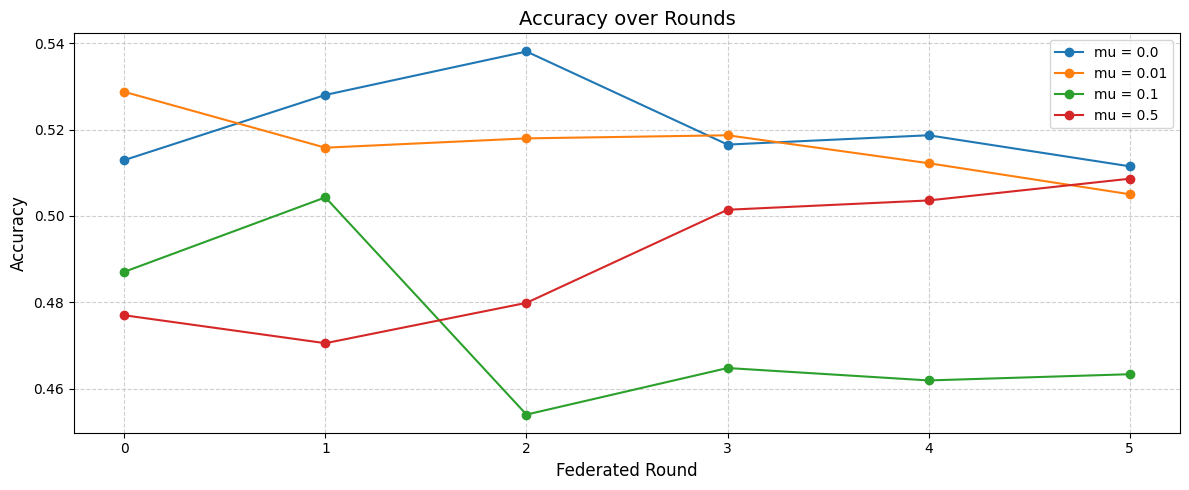

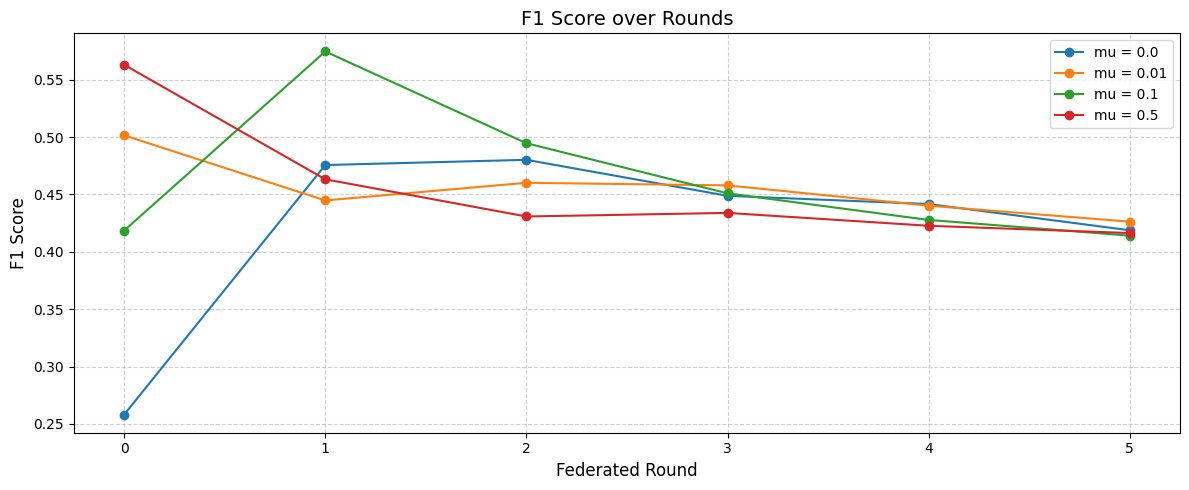

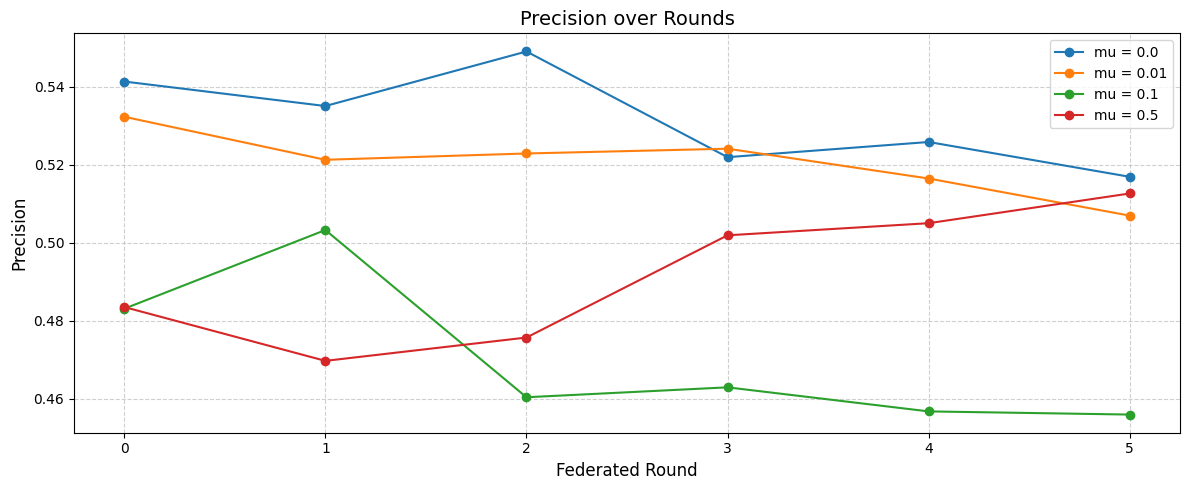

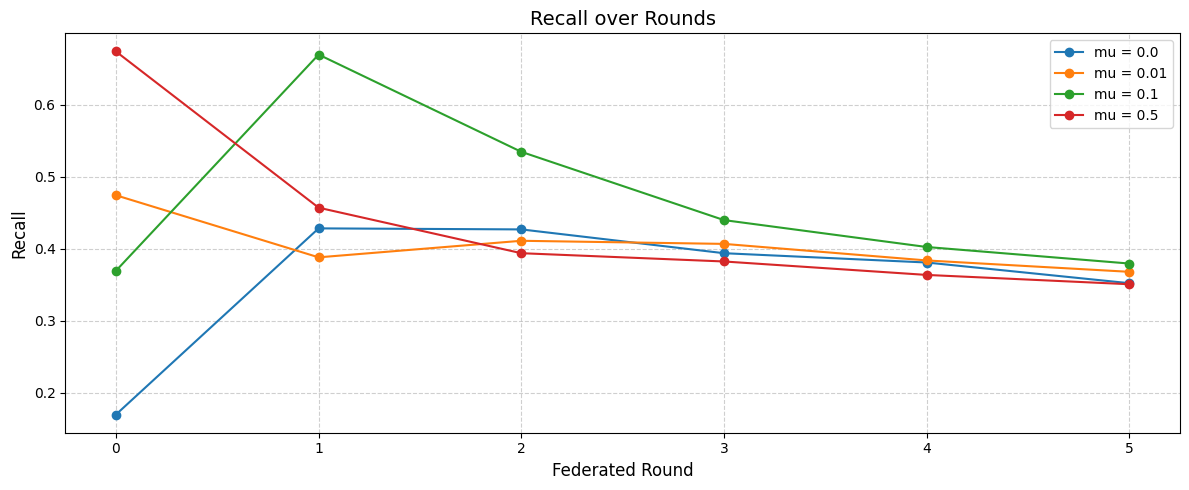

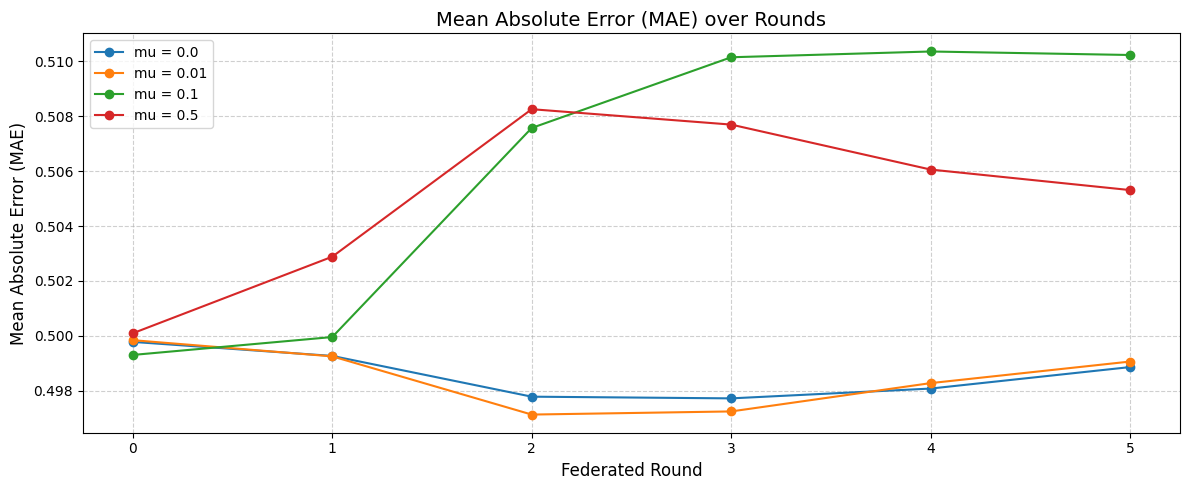

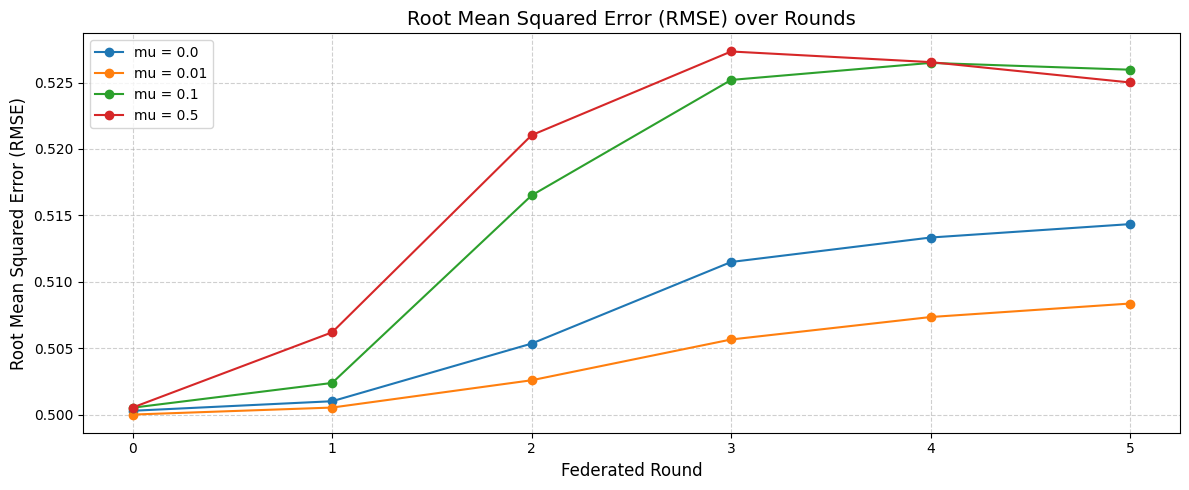

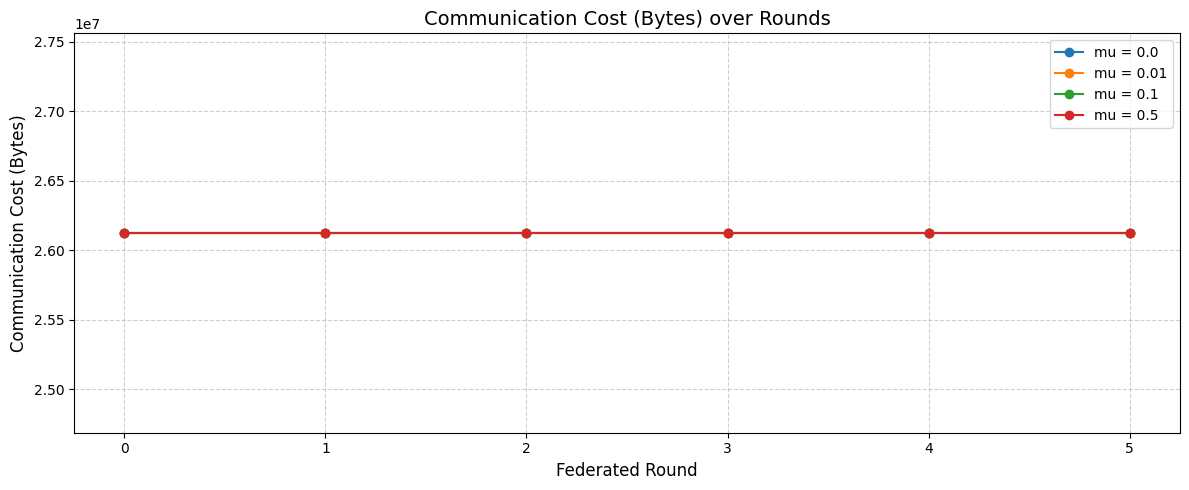

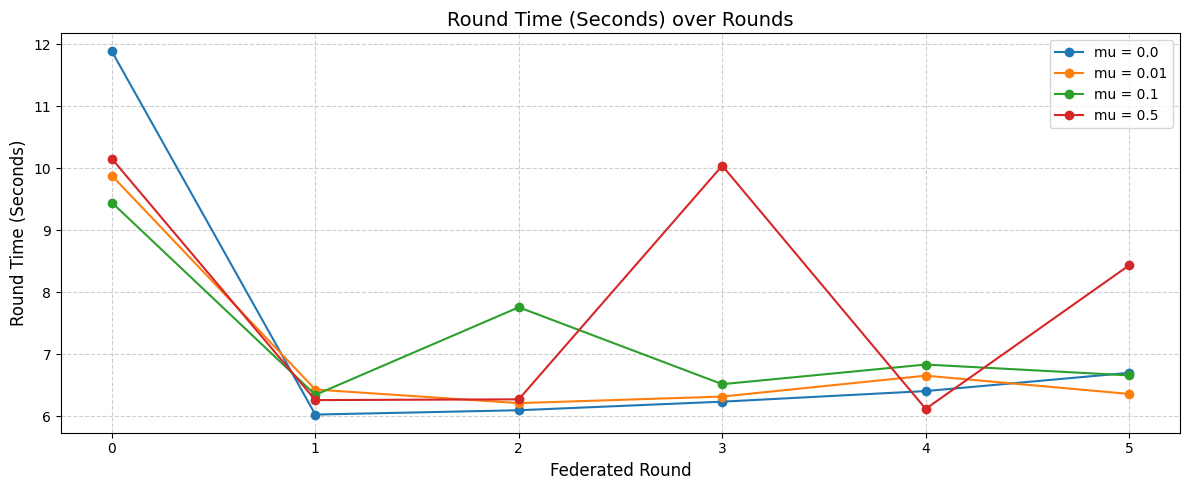

In [5]:
# --- Plotting and Saving Results ---
import matplotlib.pyplot as plt
import pandas as pd

# Liste des métriques à tracer
all_metrics = [
    "accuracy", "f1_score", "precision", "recall",
    "mae", "rmse", "comm_bytes", "round_time_sec"
]

# Titres jolis pour chaque métrique
metric_titles = {
    "accuracy": "Accuracy",
    "f1_score": "F1 Score",
    "precision": "Precision",
    "recall": "Recall",
    "mae": "Mean Absolute Error (MAE)",
    "rmse": "Root Mean Squared Error (RMSE)",
    "comm_bytes": "Communication Cost (Bytes)",
    "round_time_sec": "Round Time (Seconds)"
}

# 1. Tracer toutes les métriques et sauvegarder en PNG
for metric in all_metrics:
    plt.figure(figsize=(12, 5))
    for mu, (metrics_dict) in results.items():
        plt.plot(metrics_dict[metric], marker='o', label=f"mu = {mu}")
    plt.title(f"{metric_titles[metric]} over Rounds", fontsize=14)
    plt.xlabel("Federated Round", fontsize=12)
    plt.ylabel(metric_titles[metric], fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{metric}_fedprox_comparison.png")
    plt.show()

# 2. Exporter les résultats de chaque mu en fichier CSV
for mu, (metrics_dict) in results.items():
    df = pd.DataFrame(metrics_dict)
    df.to_csv(f"fedprox_mu_{mu}.csv", index=False)
